# Importing libraries

In [70]:
# Install tokenizer tool.
!pip install git+https://github.com/erikavaris/tokenizer.git

  Cloning https://github.com/erikavaris/tokenizer.git to /tmp/pip-req-build-ral8adh8
  Running command git clone -q https://github.com/erikavaris/tokenizer.git /tmp/pip-req-build-ral8adh8
  Created wheel for tokenizer: filename=tokenizer-1.0.1-cp36-none-any.whl size=12978 sha256=2995d7000eb7154f6faf98bed0f1c94e301f25aa7618f94d94a315f4fbaf8ecd
  Stored in directory: /tmp/pip-ephem-wheel-cache-5i6fdvxr/wheels/47/e7/9b/7f3e9b2989a5600b42ffbcc0fd8687562b1738f585f6bd92fa
Successfully built tokenizer


In [324]:
# Import essential libraries.
import os
import gensim
import nltk
nltk.download('stopwords')
import string
import numpy as np
import pandas as pd
from gensim.models.word2vec import Word2Vec
from tokenizer import tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.preprocessing import sequence
from keras.layers import Dense, Flatten, Dropout, SimpleRNN, LSTM, GRU
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data processing

In [0]:
# Read the training dataset from the file.
df = pd.read_csv('twitter-train.tsv', sep = '\t', names = ["tweet_id", "label", "tweet"], index_col = 0)
X_train = df.iloc[:, [False, True]]
Y_train = df.loc[:, [True, False]]

In [0]:
# Read the validation dataset from the file.
df = pd.read_csv('twitter-dev.tsv', sep = '\t', names = ["tweet_id", "label", "tweet"], index_col = 0)
X_val = df.iloc[:, [False, True]]
Y_val = df.loc[:, [True, False]]

In [327]:
# Read the test dataset from the file.
df = pd.read_csv('twitter-test.tsv', sep = '\t', names = ["tweet_id", "label", "tweet"], index_col = 0)
X_test = df.iloc[:, [False, True]]
Y_test = df.loc[:, [True, False]]

neutral     1513
positive    1475
negative     559
Name: label, dtype: int64


# Creating word embeddings

In [0]:
# Initialize the tokenizer.
alphabetical = set(string.ascii_lowercase)
T = tokenizer.TweetTokenizer(preserve_handles = False, preserve_hashes = True,
                             preserve_case = False, preserve_url = False,
                             preserve_emoji = False, regularize = True)

In [0]:
# Function for checking the string for alpha-numeric characters.
def alphabetic(x):
    for alpha in x:
        if not alpha.isalnum():
            return False
    
    return True

In [0]:
# Function for processing and cleaning the tweets.
def tweet_tokenize(tweet):
    tweet = tweet.replace('\\u2019', "'")
    tweet = tweet.replace('\\u002c', ',')
    text = T.tokenize(tweet)
    text = filter(lambda x: alphabetic(x), text)
    text = filter(lambda x: x not in ['rt'], text)
    text = filter(lambda x: x not in alphabetical, text)
    tweet = " ".join(text)

    return tweet

In [0]:
# Clean the datasets.
X_train['cleaned_tweet'] = X_train.apply(lambda row: tweet_tokenize(row['tweet']), axis = 1)
X_val['cleaned_tweet'] = X_val.apply(lambda row: tweet_tokenize(row['tweet']), axis = 1)
X_test['cleaned_tweet'] = X_test.apply(lambda row: tweet_tokenize(row['tweet']), axis = 1)

In [332]:
# Initialize the word2vec model.
embedding_dimension = 200
tweet_word2vec = Word2Vec(sentences = [x.split() for x in X_train['cleaned_tweet'].append(X_val['cleaned_tweet'])],
                          size = embedding_dimension, window = 5, workers = 4, min_count = 4, iter = 5)
words = list(tweet_word2vec.wv.vocab)

filename = 'embedding_word2vec.txt'
tweet_word2vec.wv.save_word2vec_format(filename, binary = False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Generate the word vectors for the individual tokens in the tweet.
top_words = len(tweet_word2vec.wv.vocab)
max_length = 35

tokenizer = Tokenizer(num_words = top_words)
tokenizer.fit_on_texts([x for x in X_train['cleaned_tweet'].append(X_val['cleaned_tweet'])])
sequences_train = tokenizer.texts_to_sequences([x for x in X_train['cleaned_tweet']])
sequences_test = tokenizer.texts_to_sequences([x for x in X_test['cleaned_tweet']])
sequences_val = tokenizer.texts_to_sequences([x for x in X_val['cleaned_tweet']])

XTrain = sequence.pad_sequences(sequences_train, padding = 'post', maxlen = max_length)
XTest = sequence.pad_sequences(sequences_test, padding = 'post', maxlen = max_length)
XVal = sequence.pad_sequences(sequences_val, padding = 'post', maxlen = max_length)

In [0]:
# Store the individual tweet-level word vectors in the desired shape and format.
embedding_index = {}
f = open('embedding_word2vec.txt', encoding = 'utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1 :])
    embedding_index[word] = coefs

f.close()

In [0]:
num_words = top_words + 1
embedding_matrix = np.zeros((num_words, embedding_dimension))
count = 0

for i, word in tokenizer.index_word.items():
    if i > top_words:
        break

    embedding_vector = embedding_index.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        count += 1

In [0]:
# Function for labelling the neutral, positive and negative sentiments as integers.
def labeller(x):
    if x == 'neutral':
        return 0
    if x == 'positive':
        return 1
    if x == 'negative':
        return 2

In [337]:
# Process the labels and change to one-hot vectors.
Y_train['label'] = Y_train['label'].apply(lambda x: labeller(x))
YTrain = to_categorical(Y_train['label'].values)
Y_val['label'] = Y_val['label'].apply(lambda x: labeller(x))
YVal = to_categorical(Y_val['label'].values)
Y_test['label'] = Y_test['label'].apply(lambda x: labeller(x))
YTest = to_categorical(Y_test['label'].values)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Creating and fitting the model

# Feed-Forward Network

In [338]:
# Simple FFN Model.
model = Sequential()
model.add(Embedding(num_words, embedding_dimension, embeddings_initializer = Constant(embedding_matrix),
                    input_length = max_length, trainable = True))
model.add(Flatten())
model.add(Dense(200, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

ffn = model.fit(XTrain, YTrain, batch_size = 256, epochs = 10, validation_data = (XVal, YVal))

Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_55 (Embedding)     (None, 35, 200)           943000    
_________________________________________________________________
flatten_9 (Flatten)          (None, 7000)              0         
_________________________________________________________________
dense_105 (Dense)            (None, 200)               1400200   
_________________________________________________________________
dropout_114 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_106 (Dense)            (None, 50)                10050     
_________________________________________________________________
dropout_115 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_107 (Dense)            (None, 3)               

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9684 samples, validate on 1654 samples
Epoch 1/10
9684/9684 [==============================] - 3s 309us/step - loss: 1.0174 - accuracy: 0.4646 - val_loss: 1.0329 - val_accuracy: 0.4528
Epoch 2/10
9684/9684 [==============================] - 3s 290us/step - loss: 0.9878 - accuracy: 0.4927 - val_loss: 1.0190 - val_accuracy: 0.4607
Epoch 3/10
9684/9684 [==============================] - 3s 287us/step - loss: 0.9633 - accuracy: 0.5141 - val_loss: 1.0100 - val_accuracy: 0.4764
Epoch 4/10
9684/9684 [==============================] - 3s 290us/step - loss: 0.9176 - accuracy: 0.5433 - val_loss: 0.9739 - val_accuracy: 0.4879
Epoch 5/10
9684/9684 [==============================] - 3s 295us/step - loss: 0.8359 - accuracy: 0.5982 - val_loss: 0.9590 - val_accuracy: 0.5375
Epoch 6/10
9684/9684 [==============================] - 3s 289us/step - loss: 0.7145 - accuracy: 0.6696 - val_loss: 0.9810 - val_accuracy: 0.5024
Epoch 7/10
9684/9684 [==============================] - 3s 288us/step - loss

In [339]:
# Present the various metrics.
score = model.evaluate(XTest, YTest, batch_size = 256, verbose = 1)
print("\nResults for Feed-Forward Neural Network")
print("Test Loss: %.2f" % (score[0]))
print("Test Accuracy: %.2f%%" % (score[1] * 100))

YPred = model.predict_classes(XTest)
print(classification_report(Y_test['label'].values, YPred, target_names = ['Neutral Class', 'Positive Class', 'Negative Class']))

3547/3547 [==============================] - 0s 65us/step

Results for Feed-Forward Neural Network
Test Loss: 1.37
Test Accuracy: 62.33%
                precision    recall  f1-score   support

 Neutral Class       0.59      0.79      0.67      1513
Positive Class       0.70      0.56      0.63      1475
Negative Class       0.58      0.33      0.42       559

      accuracy                           0.62      3547
     macro avg       0.62      0.56      0.57      3547
  weighted avg       0.63      0.62      0.61      3547



[[1194  262   57]
 [ 565  832   78]
 [ 281   93  185]]


[Text(0, 0.5, 'Neutral'), Text(0, 1.5, 'Positive'), Text(0, 2.5, 'Negative')]

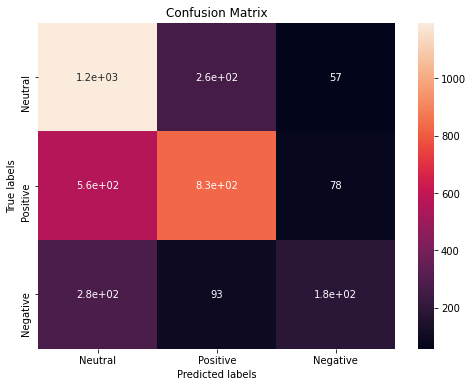

In [340]:
# Plot the confusion matrix per class.
cm = confusion_matrix(Y_test['label'].values, YPred, labels = [0, 1, 2])
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])

## Recurrent Neural Network

In [381]:
# Simple RNN Model.
model = Sequential()
model.add(Embedding(num_words, embedding_dimension, embeddings_initializer = Constant(embedding_matrix),
                    input_length = max_length, trainable = True))
model.add(SimpleRNN(200, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

rnn = model.fit(XTrain, YTrain, batch_size = 256, epochs = 8, validation_data = (XVal, YVal))

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_72 (Embedding)     (None, 35, 200)           943000    
_________________________________________________________________
simple_rnn_63 (SimpleRNN)    (None, 35, 200)           80200     
_________________________________________________________________
dropout_148 (Dropout)        (None, 35, 200)           0         
_________________________________________________________________
simple_rnn_64 (SimpleRNN)    (None, 50)                12550     
_________________________________________________________________
dropout_149 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_124 (Dense)            (None, 3)                 153       
Total params: 1,035,903
Trainable params: 1,035,903
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9684 samples, validate on 1654 samples
Epoch 1/8
9684/9684 [==============================] - 8s 875us/step - loss: 1.0230 - accuracy: 0.4592 - val_loss: 1.0525 - val_accuracy: 0.4456
Epoch 2/8
9684/9684 [==============================] - 8s 814us/step - loss: 0.9930 - accuracy: 0.4932 - val_loss: 1.0303 - val_accuracy: 0.4667
Epoch 3/8
9684/9684 [==============================] - 8s 810us/step - loss: 0.9618 - accuracy: 0.5325 - val_loss: 1.0299 - val_accuracy: 0.4504
Epoch 4/8
9684/9684 [==============================] - 8s 815us/step - loss: 0.9039 - accuracy: 0.5881 - val_loss: 0.9976 - val_accuracy: 0.5411
Epoch 5/8
9684/9684 [==============================] - 8s 827us/step - loss: 0.7855 - accuracy: 0.6732 - val_loss: 0.9591 - val_accuracy: 0.5804
Epoch 6/8
9684/9684 [==============================] - 8s 823us/step - loss: 0.6871 - accuracy: 0.7137 - val_loss: 0.9756 - val_accuracy: 0.5804
Epoch 7/8
9684/9684 [==============================] - 8s 820us/step - loss: 0.631

In [382]:
# Present the various metrics.
score = model.evaluate(XTest, YTest, batch_size = 256, verbose = 1)
print("\nResults for Recurrent Neural Network")
print("Test Loss: %.2f" % (score[0]))
print("Test Accuracy: %.2f%%" % (score[1] * 100))

YPred = model.predict_classes(XTest)
print(classification_report(Y_test['label'].values, YPred, target_names = ['Neutral Class', 'Positive Class', 'Negative Class']))

3547/3547 [==============================] - 1s 395us/step

Results for Recurrent Neural Network
Test Loss: 0.99
Test Accuracy: 61.77%
                precision    recall  f1-score   support

 Neutral Class       0.59      0.81      0.68      1513
Positive Class       0.65      0.65      0.65      1475
Negative Class       0.00      0.00      0.00       559

      accuracy                           0.62      3547
     macro avg       0.42      0.49      0.45      3547
  weighted avg       0.52      0.62      0.56      3547



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[1225  288    0]
 [ 509  966    0]
 [ 333  226    0]]


[Text(0, 0.5, 'Neutral'), Text(0, 1.5, 'Positive'), Text(0, 2.5, 'Negative')]

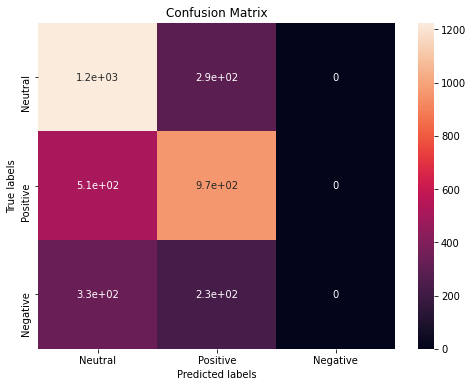

In [383]:
# Plot the confusion matrix per class.
cm = confusion_matrix(Y_test['label'].values, YPred, labels = [0, 1, 2])
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])

## Gated Recurrent Neural Network

In [367]:
# Simple GRNN Model.
model = Sequential()
model.add(Embedding(num_words, embedding_dimension, embeddings_initializer = Constant(embedding_matrix),
                    input_length = max_length, trainable = True))
model.add(GRU(200, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(GRU(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

gru = model.fit(XTrain, YTrain, batch_size = 256, epochs = 10, validation_data = (XVal, YVal))

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (None, 35, 200)           943000    
_________________________________________________________________
gru_11 (GRU)                 (None, 35, 200)           240600    
_________________________________________________________________
dropout_136 (Dropout)        (None, 35, 200)           0         
_________________________________________________________________
gru_12 (GRU)                 (None, 100)               90300     
_________________________________________________________________
dropout_137 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_118 (Dense)            (None, 3)                 303       
Total params: 1,274,203
Trainable params: 1,274,203
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9684 samples, validate on 1654 samples
Epoch 1/10
9684/9684 [==============================] - 30s 3ms/step - loss: 1.0293 - accuracy: 0.4673 - val_loss: 1.0568 - val_accuracy: 0.4468
Epoch 2/10
9684/9684 [==============================] - 29s 3ms/step - loss: 1.0027 - accuracy: 0.4771 - val_loss: 1.0382 - val_accuracy: 0.4607
Epoch 3/10
9684/9684 [==============================] - 29s 3ms/step - loss: 0.9864 - accuracy: 0.4983 - val_loss: 1.0208 - val_accuracy: 0.4667
Epoch 4/10
9684/9684 [==============================] - 29s 3ms/step - loss: 0.9589 - accuracy: 0.5246 - val_loss: 0.9904 - val_accuracy: 0.5018
Epoch 5/10
9684/9684 [==============================] - 29s 3ms/step - loss: 0.8756 - accuracy: 0.5994 - val_loss: 0.9663 - val_accuracy: 0.5441
Epoch 6/10
9684/9684 [==============================] - 32s 3ms/step - loss: 0.7354 - accuracy: 0.6835 - val_loss: 0.9220 - val_accuracy: 0.5798
Epoch 7/10
9684/9684 [==============================] - 29s 3ms/step - loss: 0.657

In [368]:
# Present the various metrics.
score = model.evaluate(XTest, YTest, batch_size = 256, verbose = 1)
print("\nResults for Gated Recurrent Neural Network")
print("Test Loss: %.2f" % (score[0]))
print("Test Accuracy: %.2f%%" % (score[1] * 100))

YPred = model.predict_classes(XTest)
print(classification_report(Y_test['label'].values, YPred, target_names = ['Neutral Class', 'Positive Class', 'Negative Class']))

3547/3547 [==============================] - 2s 655us/step

Results for Gated Recurrent Neural Network
Test Loss: 1.21
Test Accuracy: 62.11%
                precision    recall  f1-score   support

 Neutral Class       0.63      0.74      0.68      1513
Positive Class       0.64      0.65      0.64      1475
Negative Class       0.48      0.25      0.32       559

      accuracy                           0.62      3547
     macro avg       0.58      0.54      0.55      3547
  weighted avg       0.61      0.62      0.61      3547



[[1113  352   48]
 [ 422  953  100]
 [ 233  189  137]]


[Text(0, 0.5, 'Neutral'), Text(0, 1.5, 'Positive'), Text(0, 2.5, 'Negative')]

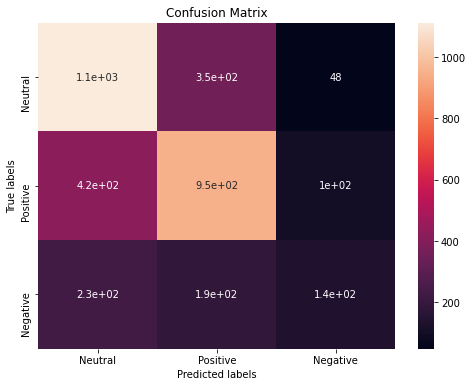

In [369]:
# Plot the confusion matrix per class.
cm = confusion_matrix(Y_test['label'].values, YPred, labels = [0, 1, 2])
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])

## Long Short Term Memory Network

In [372]:
# Simple LSTM Model.
model = Sequential()
model.add(Embedding(num_words, embedding_dimension, embeddings_initializer = Constant(embedding_matrix),
                    input_length = max_length, trainable = True))
model.add(LSTM(200, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(100, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

lstm = model.fit(XTrain, YTrain, batch_size = 256, epochs = 5, validation_data = (XVal, YVal))

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_69 (Embedding)     (None, 35, 200)           943000    
_________________________________________________________________
lstm_24 (LSTM)               (None, 35, 200)           320800    
_________________________________________________________________
dropout_142 (Dropout)        (None, 35, 200)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               120400    
_________________________________________________________________
dropout_143 (Dropout)        (None, 100)               0         
_________________________________________________________________
dense_121 (Dense)            (None, 3)                 303       
Total params: 1,384,503
Trainable params: 1,384,503
Non-trainable params: 0
___________________________________________

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 9684 samples, validate on 1654 samples
Epoch 1/5
9684/9684 [==============================] - 32s 3ms/step - loss: 1.0177 - accuracy: 0.4633 - val_loss: 1.0304 - val_accuracy: 0.4589
Epoch 2/5
9684/9684 [==============================] - 31s 3ms/step - loss: 0.9836 - accuracy: 0.4975 - val_loss: 1.0504 - val_accuracy: 0.4504
Epoch 3/5
9684/9684 [==============================] - 31s 3ms/step - loss: 0.9465 - accuracy: 0.5354 - val_loss: 0.9791 - val_accuracy: 0.5048
Epoch 4/5
9684/9684 [==============================] - 31s 3ms/step - loss: 0.8423 - accuracy: 0.6169 - val_loss: 0.9611 - val_accuracy: 0.5502
Epoch 5/5
9684/9684 [==============================] - 31s 3ms/step - loss: 0.7228 - accuracy: 0.6864 - val_loss: 1.0118 - val_accuracy: 0.5744


In [373]:
# Present the various metrics.
score = model.evaluate(XTest, YTest, batch_size = 256, verbose = 1)
print("\nResults for Long Short Term Memory Network")
print("Test Loss: %.2f" % (score[0]))
print("Test Accuracy: %.2f%%" % (score[1] * 100))

YPred = model.predict_classes(XTest)
print(classification_report(Y_test['label'].values, YPred, target_names = ['Neutral Class', 'Positive Class', 'Negative Class']))

3547/3547 [==============================] - 3s 781us/step

Results for Long Short Term Memory Network
Test Loss: 0.96
Test Accuracy: 61.77%
                precision    recall  f1-score   support

 Neutral Class       0.62      0.80      0.70      1513
Positive Class       0.62      0.67      0.64      1475
Negative Class       0.00      0.00      0.00       559

      accuracy                           0.62      3547
     macro avg       0.41      0.49      0.45      3547
  weighted avg       0.52      0.62      0.56      3547



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[1209  304    0]
 [ 493  982    0]
 [ 256  303    0]]


[Text(0, 0.5, 'Neutral'), Text(0, 1.5, 'Positive'), Text(0, 2.5, 'Negative')]

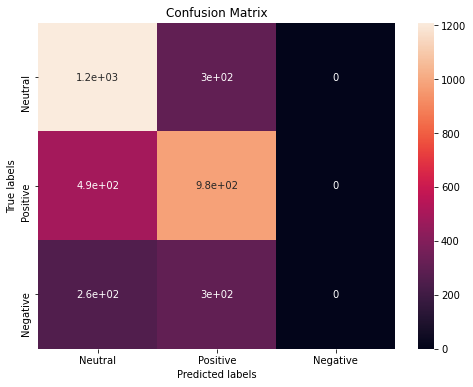

In [374]:
# Plot the confusion matrix per class.
cm = confusion_matrix(Y_test['label'].values, YPred, labels = [0, 1, 2])
print(cm)
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])
ax.yaxis.set_ticklabels(['Neutral', 'Positive', 'Negative'])